In [5]:
from scipy.constants import epsilon_0
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
% matplotlib inline
from SimPEG.Utils import ndgrid, mkvc
from ipywidgets import *

# Setup:

Sphere in a wholespace with a constant, uniform electric field

Parameters:

 - $\sigma_0$ : conductivity of the background
 - $\sigma_1$ : conductivity of the sphere
 - $ R $: radius of the sphere
 - $ r $: distance between measurement point and origin of sphere
 - $ E_0$: primary uniform electric field
 - $(r,\theta,\phi)$, spherical coordiante
 - $(x, y, z)$, Cartesian coordiante

http://www.3ptscience.com/app/DCresistivity

# Parameters for the sphere Problem


In [6]:
sig0 = 10.          # conductivity of the wholespace
sig1 = 100.         # conductivity of the sphere
R    = 50.          # radius of the sphere
E0   = 1.           # inducing field strength
n = 100             #level of discretisation
xr = np.linspace(-2.*R, 2.*R, n) # X-axis discretization
yr = xr.copy()      # Y-axis discretization
dx = xr[1]-xr[0]       # mesh spacing
dy = yr[1]-yr[0]       # mesh spacing
zr = np.r_[0]          # identical to saying `zr = np.array([0])`
XYZ = ndgrid(xr,yr,zr) # Space Definition
ftsize_title = 24      #font size for titles
ftsize_axis  = 16      #font size for axis ticks
ftsize_label = 18      #font size for axis labels

In [7]:
# Radius function and useful sigma ratio
r  = lambda x,y,z: np.sqrt(x**2.+y**2.+z**2.)
sigf = lambda sig0,sig1: (sig1-sig0)/(sig1+2.*sig0)

In [8]:
# Define the conductivity for each point of the space
def get_Conductivity(XYZ,sig0,sig1,R):
    x,y,z = XYZ[:,0],XYZ[:,1],XYZ[:,2]
    r_view=r(x,y,z)
    
    ind0= (r_view>R)
    ind1= (r_view<=R)
    
    assert (ind0 + ind1).all(), 'Some indicies not included'
    
    Sigma = np.zeros_like(x)
    
    Sigma[ind0] = sig0
    Sigma[ind1] = sig1
    
    return Sigma

# Potentials Computation

For a uniform electrostatic field, we can define a scalar potential so that the primary electric field can be described as the negative gradient of the primary potential as
$$ E_p = -\nabla V_p $$

Assuming a x-directed uniform electric field and zero potential at infinity, by integration, we obtain
$$ V_p = -E_0 x = -E_0 r\cos\theta $$

The total potential outside the sphere ($ r>R $) is
$$ V_1 = -E_0 r\cos\theta (1-\frac{R^3}{r^3}\frac{\sigma_1 - \sigma_0}{\sigma_1 + 2\sigma_0}) $$
and inside the sphere ($ r<R $) is
$$ V_2 = -E_0 \frac{3\sigma_0}{\sigma_1+2\sigma_0}r\cos\theta $$

Note that $ x=r\cos\theta $ (transformation between spherical coordinate and Cartesian coordinate systems).

In [9]:
# Function that returns the total, the primary and the seconadry potentials,
# assumes an x-oriented inducing field and that the sphere is at the origin
# input: grid, outer sigma, inner sigma, radius of the sphere, strenght of the electric field

def get_Potential(XYZ,sig0,sig1,R,E0): 
    
    x,y,z = XYZ[:,0],XYZ[:,1],XYZ[:,2]
    
    sig_cur = sigf(sig0,sig1)
    
    r_cur = r(x,y,z)  # current radius
    
    ind0 = (r_cur > R)
    ind1 = (r_cur <= R)
    
    assert (ind0 + ind1).all(), 'Some indicies not included'
    
    Vt = np.zeros_like(x)
    Vp = np.zeros_like(x)
    Vs = np.zeros_like(x)
    
    Vt[ind0] = -E0*x[ind0]*(1.-sig_cur*R**3./r_cur[ind0]**3.) # total potential outside the sphere
    Vt[ind1] = -E0*x[ind1]*3.*sig0/(sig1+2.*sig0)             # inside the sphere
    
    
    Vp = - E0*x  # primary potential
    
    Vs = Vt - Vp # secodary potential
    
    return Vt,Vp,Vs

In [10]:
#def get_Primary_Potential(XYZ,sig0,sig1,R,E0):
#   x = XYZ[:,0]
#   return - E0*x

<function __main__.plot_Potentials>

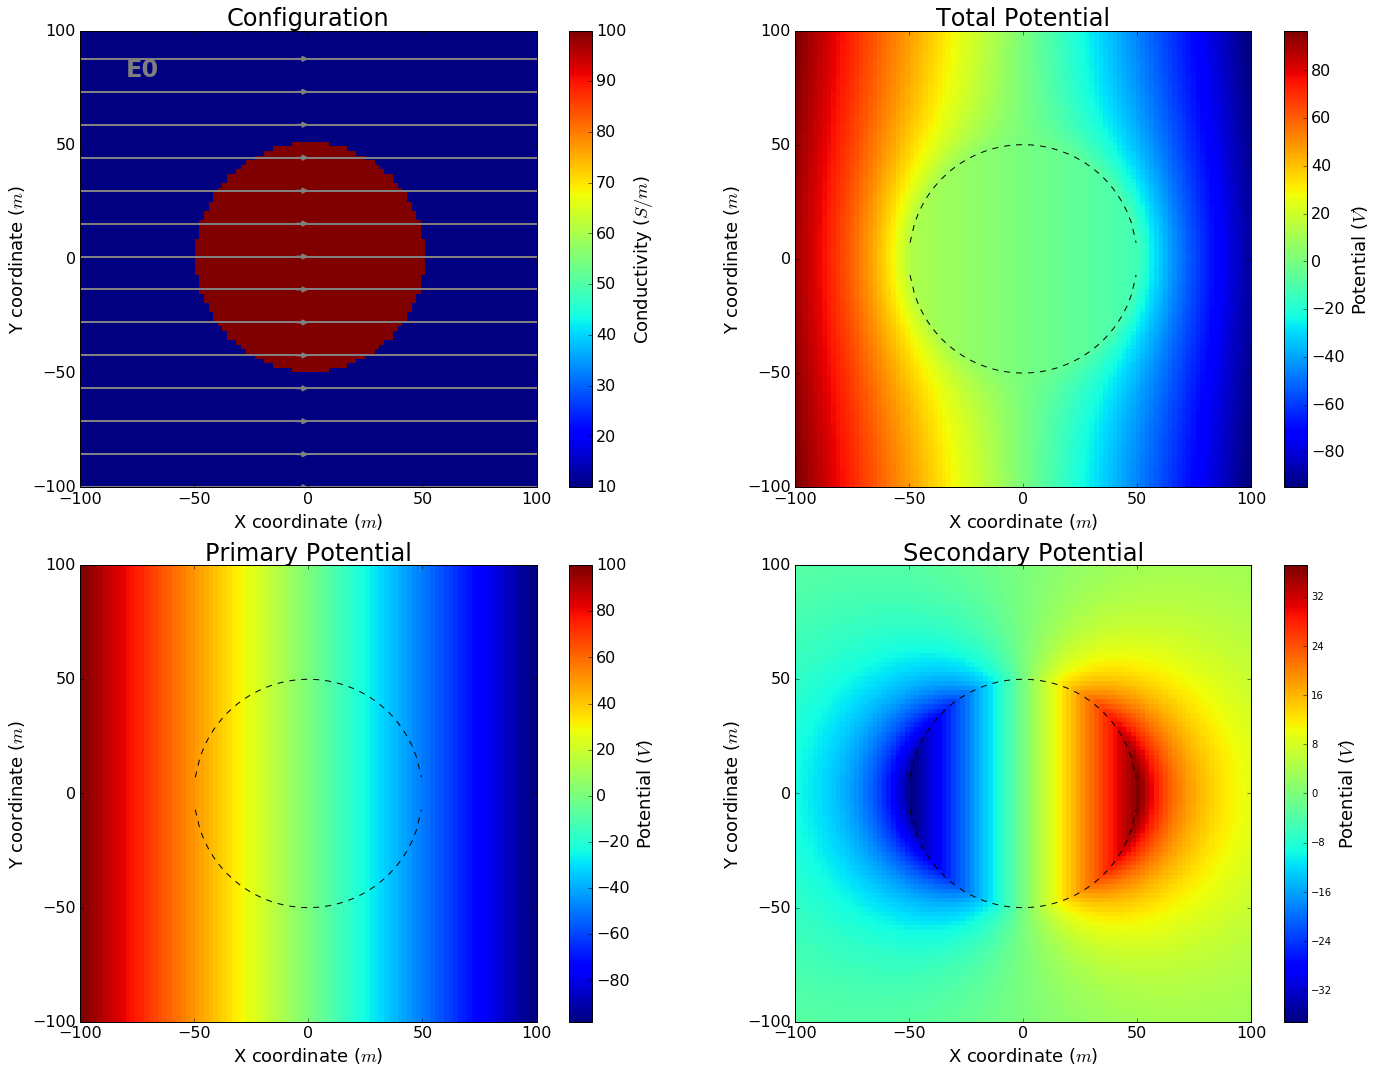

In [31]:
# Interactive tool to visualise the primary, secondary and total potentials

R_slider  = FloatSlider(min=0., max =50., step=10.,value=50.)
S1_slider = FloatSlider(min=1., max =100., step=1.,value=100.)
S0_slider = FloatSlider(min=1., max =100., step=1.,value=10.)
E0_slider = FloatSlider(min=-10., max =10., step=1.,value=1.)

def plot_Potentials(R,sig1,sig0,E0):
    
    Sigma    = get_Conductivity(XYZ,sig0,sig1,R)
    Vt,Vp,Vs = get_Potential(XYZ,sig0,sig1,R,E0)
        
    Ep = np.zeros(shape=(len(Sigma),3))
    Ep[:,0] = E0
    #Vp = get_Primary_Potential(XYZ,sig0,sig1,R,E0)

    xcirc = xr[np.abs(xr) <= R]

    fig,ax = plt.subplots(2,2,figsize=(20,15))
    ax=mkvc(ax)

    ax[0].pcolor(xr,yr,Sigma.reshape(xr.size, yr.size))
    cb0 = plt.colorbar(ax[0].pcolor(xr,yr,Sigma.reshape(xr.size, yr.size)),ax=ax[0])
    cb0.set_label(label= 'Conductivity ($S/m$)',size=ftsize_label) #weight='bold')
    cb0.ax.tick_params(labelsize=ftsize_axis)
    plt.tick_params(labelsize=ftsize_axis)
    ax[0].streamplot(xr,yr,Ep[:,0].reshape(xr.size,yr.size),Ep[:,1].reshape(xr.size,yr.size),color='gray'
                     ,density=0.5, linewidth=2.)
    ax[0].annotate('E0',(-80,80),xytext=(-80,80),fontsize=ftsize_title,color='gray',weight='bold')
    #ax[0].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
    ax[0].set_title('Configuration',fontsize=ftsize_title)
    ax[0].set_xlim([xr.min(),xr.max()])
    ax[0].set_ylim([yr.min(),yr.max()])
    ax[0].set_ylabel('Y coordinate ($m$)',fontsize = ftsize_label)
    ax[0].set_xlabel('X coordinate ($m$)',fontsize = ftsize_label)
    ax[0].set_aspect('equal')
    ax[0].tick_params(labelsize=ftsize_axis)


    ax[1].pcolor(xr,yr,Vp.reshape(xr.size,yr.size))
    ax[1].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
    ax[1].set_title('Primary Potential',fontsize=ftsize_title)
    cb1 = plt.colorbar(ax[1].pcolor(xr,yr,Vp.reshape(xr.size, yr.size)),ax=ax[1])
    cb1.set_label(label= 'Potential ($V$)',size=ftsize_label)
    cb1.ax.tick_params(labelsize=ftsize_axis)
    ax[1].set_xlim([xr.min(),xr.max()])
    ax[1].set_ylim([yr.min(),yr.max()])
    ax[1].set_ylabel('Y coordinate ($m$)',fontsize = ftsize_label)
    ax[1].set_xlabel('X coordinate ($m$)',fontsize = ftsize_label)
    ax[1].set_aspect('equal')
    ax[1].tick_params(labelsize=ftsize_axis)


    ax[2].pcolor(xr,yr,Vt.reshape(xr.size,yr.size))
    ax[2].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
    ax[2].set_title('Total Potential',fontsize=ftsize_title)
    cb2 = plt.colorbar(ax[2].pcolor(xr,yr,Vt.reshape(xr.size, yr.size)),ax=ax[2])
    cb2.set_label(label= 'Potential ($V$)',size=ftsize_label)
    cb2.ax.tick_params(labelsize=ftsize_axis)
    ax[2].set_xlim([xr.min(),xr.max()])
    ax[2].set_ylim([yr.min(),yr.max()])
    ax[2].set_ylabel('Y coordinate ($m$)',fontsize = ftsize_label)
    ax[2].set_xlabel('X coordinate ($m$)',fontsize = ftsize_label)
    ax[2].set_aspect('equal')
    ax[2].tick_params(labelsize=ftsize_axis)

    ax[3].pcolor(xr,yr,Vs.reshape(xr.size,yr.size))
    ax[3].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
    ax[3].set_title('Secondary Potential',fontsize=ftsize_title)
    cb3 = plt.colorbar(ax[3].pcolor(xr,yr,Vs.reshape(xr.size, yr.size)),ax=ax[3])
    cb3.set_label(label= 'Potential ($V$)',size=ftsize_label)
    cb2.ax.tick_params(labelsize=ftsize_axis)
    ax[3].set_xlim([xr.min(),xr.max()])
    ax[3].set_ylim([yr.min(),yr.max()])
    ax[3].set_ylabel('Y coordinate ($m$)',fontsize = ftsize_label)
    ax[3].set_xlabel('X coordinate ($m$)',fontsize = ftsize_label)
    ax[3].set_aspect('equal')
    ax[3].tick_params(labelsize=ftsize_axis)



    plt.tight_layout()
    
interact(plot_Potentials, R=R_slider, sig1=S1_slider, sig0=S0_slider,E0=E0_slider)

# Electric Field Computation

The electric field outside the sphere ($ r>R $) is
$$ E_1 = E_0\hat{x} + E_0R^3\frac{\sigma_1-\sigma_0}{\sigma_1+2\sigma_0}\frac{1}{r^5}[(2x^2-y^2-z^2)\hat{x} + (3xy)\hat{y} + (3xz)\hat{z}] $$

and inside ($ r<R $) is
$$ E_2 = E_0\frac{3\sigma_0}{\sigma_1+2\sigma_0}\hat{x} $$

In [15]:
# Function that returns the total, the primary and the seconadry electric fields, 
# input: grid, outer sigma, inner sigma, radius of the sphere, strenght of the electric field

def get_ElectricField (XYZ,sig0,sig1,R,E0):
    
    x,y,z= XYZ[:,0], XYZ[:,1], XYZ[:,2]
    
    r_cur=r(x,y,z)  # current radius
    
    ind0= (r_cur>R)
    ind1= (r_cur<=R)
    
    assert (ind0 + ind1).all(), 'Some indicies not included'
        
    Ep = np.zeros(shape=(len(x),3))
    Ep[:,0] = E0
    
    Et = np.zeros(shape=(len(x),3))
    
    Et[ind0,0] = E0 + E0*R**3./(r_cur[ind0]**5.)*sigf(sig0,sig1)*(2.*x[ind0]**2.-y[ind0]**2.-z[ind0]**2.);
    Et[ind0,1] = E0*R**3./(r_cur[ind0]**5.)*3.*x[ind0]*y[ind0]*sigf(sig0,sig1);
    Et[ind0,2] = E0*R**3./(r_cur[ind0]**5.)*3.*x[ind0]*z[ind0]*sigf(sig0,sig1);

    Et[ind1,0] = 3.*sig0/(sig1+2.*sig0)*E0;
    Et[ind1,1] = 0.;
    Et[ind1,2] = 0.;
    
    Es = Et - Ep
    
    return Et, Ep, Es


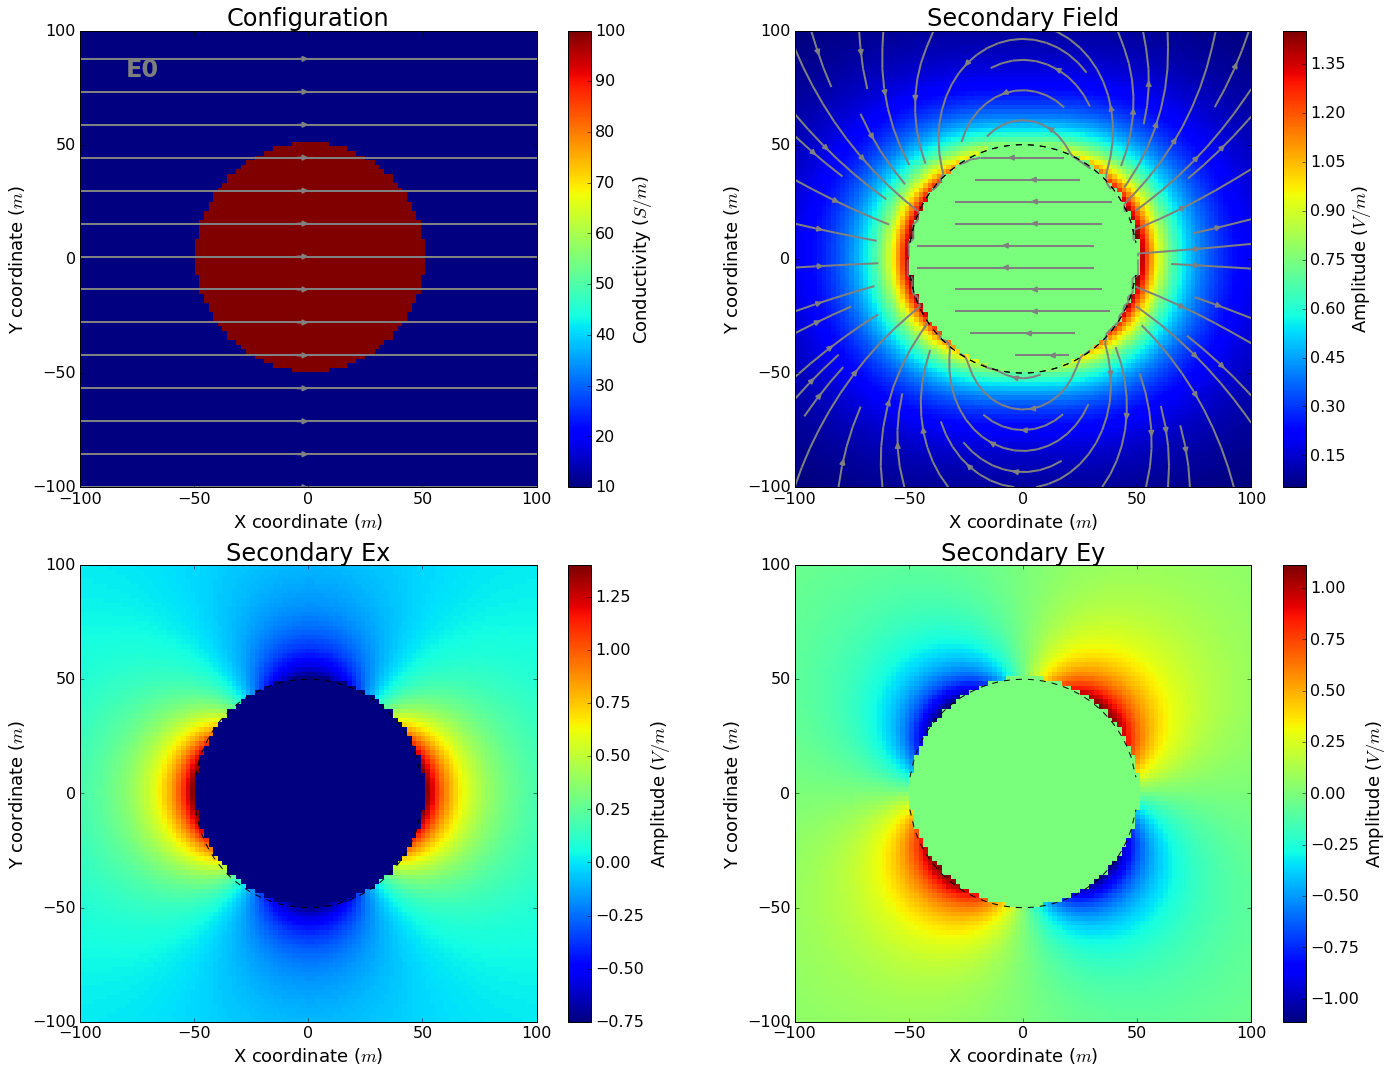

In [27]:
# Interavtice visualisation of the Electric Field

R_slider  = FloatSlider(min=0., max =50., step=10., value=50.)
S1_slider = FloatSlider(min=1., max =100., step=1.,value=100.)
S0_slider = FloatSlider(min=1., max =100., step=1.,value=10.)
E0_slider = FloatSlider(min=-10., max =10., step=2., value=1.)
PlotOpt_button = ToggleButtons(options=['Total','Secondary'],value = 'Total')


def plot_ElectricField(R,sig1,sig0,E0,PlotOpt):
   
    Sigma = get_Conductivity(XYZ,sig0,sig1,R)
    Et, Ep, Es = get_ElectricField(XYZ,sig0,sig1,R,E0)
    
    xcirc = xr[np.abs(xr) <= R]
    
    EtXr = Et[:,0].reshape(xr.size, yr.size)
    EtYr = Et[:,1].reshape(xr.size, yr.size)
    EtAmp = np.sqrt(Et[:,0]**2+Et[:,1]**2 + Et[:,2]**2).reshape(xr.size, yr.size)
    
    EsXr = Es[:,0].reshape(xr.size, yr.size)
    EsYr = Es[:,1].reshape(xr.size, yr.size)
    EsAmp = np.sqrt(Es[:,0]**2+Es[:,1]**2+Es[:,2]**2).reshape(xr.size, yr.size)
    
    fig,ax = plt.subplots(2,2,figsize=(20,15))
    ax=mkvc(ax)

    ax[0].pcolor(xr,yr,Sigma.reshape(xr.size, yr.size))
    cb0 = plt.colorbar(ax[0].pcolor(xr,yr,Sigma.reshape(xr.size, yr.size)),ax=ax[0])
    cb0.set_label(label= 'Conductivity ($S/m$)',size=ftsize_label) #weight='bold')
    cb0.ax.tick_params(labelsize=ftsize_axis)
    #ax[0].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
    ax[0].streamplot(xr,yr,Ep[:,0].reshape(xr.size,yr.size),Ep[:,1].reshape(xr.size,yr.size),color='gray'
                     ,density=0.5, linewidth=2.)
    ax[0].set_title('Configuration',fontsize=ftsize_title)
    ax[0].annotate('E0',(-80,80),xytext=(-80,80),fontsize=ftsize_title,color='gray',weight='bold')
    ax[0].set_xlim([xr.min(),xr.max()])
    ax[0].set_ylim([yr.min(),yr.max()])
    ax[0].set_ylabel('Y coordinate ($m$)',fontsize = ftsize_label)
    ax[0].set_xlabel('X coordinate ($m$)',fontsize = ftsize_label)
    ax[0].set_aspect('equal')
    ax[0].tick_params(labelsize=ftsize_axis)
    
    ax[2].set_xlim([xr.min(),xr.max()])
    ax[2].set_ylim([yr.min(),yr.max()])
    ax[2].set_ylabel('Y coordinate ($m$)',fontsize = ftsize_label)
    ax[2].set_xlabel('X coordinate ($m$)',fontsize = ftsize_label)
    ax[2].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
    ax[2].tick_params(labelsize=ftsize_axis)
    ax[2].set_aspect('equal')

    ax[1].set_xlim([xr.min(),xr.max()])
    ax[1].set_ylim([yr.min(),yr.max()])
    ax[1].set_ylabel('Y coordinate ($m$)',fontsize = ftsize_label)
    ax[1].set_xlabel('X coordinate ($m$)',fontsize = ftsize_label)
    ax[1].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
    ax[1].tick_params(labelsize=ftsize_axis)
    ax[1].set_aspect('equal')

    ax[3].set_xlim([xr.min(),xr.max()])
    ax[3].set_ylim([yr.min(),yr.max()])
    ax[3].set_ylabel('Y coordinate ($m$)',fontsize = ftsize_label)
    ax[3].set_xlabel('X coordinate ($m$)',fontsize = ftsize_label)
    ax[3].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
    ax[3].tick_params(labelsize=ftsize_axis)
    ax[3].set_aspect('equal')

    if PlotOpt == 'Total':
    
        ax[2].pcolor(xr,yr,EtAmp)
        cb2 = plt.colorbar(ax[2].pcolor(xr,yr,EtAmp),ax=ax[2])
        cb2.set_label(label= 'Amplitude ($V/m$)',size=ftsize_label) #weight='bold')
        cb2.ax.tick_params(labelsize=ftsize_axis)
        ax[2].streamplot(xr,yr,EtXr,EtYr,color='gray',linewidth=2.,density=0.75)#angles='xy',scale_units='xy',scale=0.05)
        ax[2].set_title('Total Field',fontsize=ftsize_title)

        ax[1].pcolor(xr,yr,EtXr)
        cb1 = plt.colorbar(ax[1].pcolor(xr,yr,EtXr),ax=ax[1])
        cb1.set_label(label= 'Amplitude ($V/m$)',size=ftsize_label) #weight='bold')
        cb1.ax.tick_params(labelsize=ftsize_axis)
        ax[1].set_title('Total Ex',fontsize=ftsize_title)
    
        ax[3].pcolor(xr,yr,EtYr)
        cb3 = plt.colorbar(ax[3].pcolor(xr,yr,EtYr),ax=ax[3])
        cb3.set_label(label= 'Amplitude ($V/m$)',size=ftsize_label) #weight='bold')
        cb3.ax.tick_params(labelsize=ftsize_axis)
        ax[3].set_title('Total Ey',fontsize=ftsize_title)
    
    
    elif PlotOpt is 'Secondary':

        ax[2].pcolor(xr,yr,EsAmp)
        cb2 = plt.colorbar(ax[2].pcolor(xr,yr,EsAmp),ax=ax[2])
        cb2.set_label(label= 'Amplitude ($V/m$)',size=ftsize_label) #weight='bold')
        cb2.ax.tick_params(labelsize=ftsize_axis)
        ax[2].streamplot(xr,yr,EsXr,EsYr,color='gray',linewidth=2.,density=0.75)#,angles='xy',scale_units='xy',scale=0.05)
        ax[2].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
        ax[2].set_title('Secondary Field',fontsize=ftsize_title)

        ax[1].pcolor(xr,yr,EsXr)
        cb1 = plt.colorbar(ax[1].pcolor(xr,yr,EsXr),ax=ax[1])
        cb1.set_label(label= 'Amplitude ($V/m$)',size=ftsize_label) #weight='bold')
        cb1.ax.tick_params(labelsize=ftsize_axis)
        ax[1].set_title('Secondary Ex',fontsize=ftsize_title)
    
        ax[3].pcolor(xr,yr,EsYr)
        cb3= plt.colorbar(ax[3].pcolor(xr,yr,EsYr),ax=ax[3])
        cb3.set_label(label= 'Amplitude ($V/m$)',size=ftsize_label) #weight='bold')
        cb3.ax.tick_params(labelsize=ftsize_axis)
        ax[3].set_title('Secondary Ey',fontsize=ftsize_title)
        
    else:

        print('Oups!')
        
    plt.tight_layout()
    
interact(plot_ElectricField, R=R_slider, sig1=S1_slider,sig0=S0_slider,E0=E0_slider,PlotOpt = PlotOpt_button)

# Current Density

According to Ohm's Law, the current density is $ \mathbf{J} = \sigma\mathbf{E}$.


## Total Current

Outside the sphere (r>R): $ \mathbf{J_{total}} = \sigma_0 \mathbf{E_{total}}$.

inside the sphere (r<R): $ \mathbf{J_{total}} = \sigma_1 \mathbf{E_{total}}$.


## Secondary Current

The secondary current is defined as $\mathbf{J_{secondary}} = \mathbf{J_{total}} - \mathbf{J_{primary}}$

with $ \mathbf{J_{primary}} = \sigma_0 \mathbf{E_0}$


Outside the sphere (r>R): $ \mathbf{J_{secondary}} = \sigma_0 ( \mathbf{E_{total}} - \mathbf{E_{0}} ) = \sigma_0 \mathbf{E_{secondary}} $.

inside the sphere (r<R): $ \mathbf{J_{secondary}} = \sigma_1 \mathbf{E_{total}} - \sigma_0 \mathbf{E_{0}}$.



### Corollary :  

Inside the sphere:

$ \mathbf{J_{secondary}} \neq \sigma_1 ( \mathbf{E_{total}} - \mathbf{E_{0}} ) $

$ \mathbf{J_{secondary}} \neq \sigma_1 \mathbf{E_{secondary}} $

In [17]:
# Function that returns the total, the primary and the seconadry current densities, 
# input: grid, outer sigma, inner sigma, radius of the sphere, total, the primary and the seconadry electric fields, 

def get_Current(XYZ,sig0,sig1,R,Et,Ep,Es):
    
    x,y,z= XYZ[:,0], XYZ[:,1], XYZ[:,2]
    
    
    r_cur=r(x,y,z)
    
    ind0= (r_cur>R)
    ind1= (r_cur<=R)
    
    assert (ind0 + ind1).all(), 'Some indicies not included'
    
    Jt = np.zeros(shape=(len(x),3))
    J0 = np.zeros(shape=(len(x),3))
    Js = np.zeros(shape=(len(x),3))
    

    Jp = sig0*Ep
    
    Jt[ind0,:] = sig0*Et[ind0,:]   
    Jt[ind1,:] = sig1*Et[ind1,:]

    
    #Js[ind0,:] = sig0*Es[ind0,:]
    #Js[ind1,:] = sig1*Es[ind1,:]
    Js[ind0,:] = sig0*(Et[ind0,:]-Ep[ind0,:])
    Js[ind1,:] = sig1*Et[ind1,:]-sig0*Ep[ind1,:]
    
    return Jt,Jp,Js
    

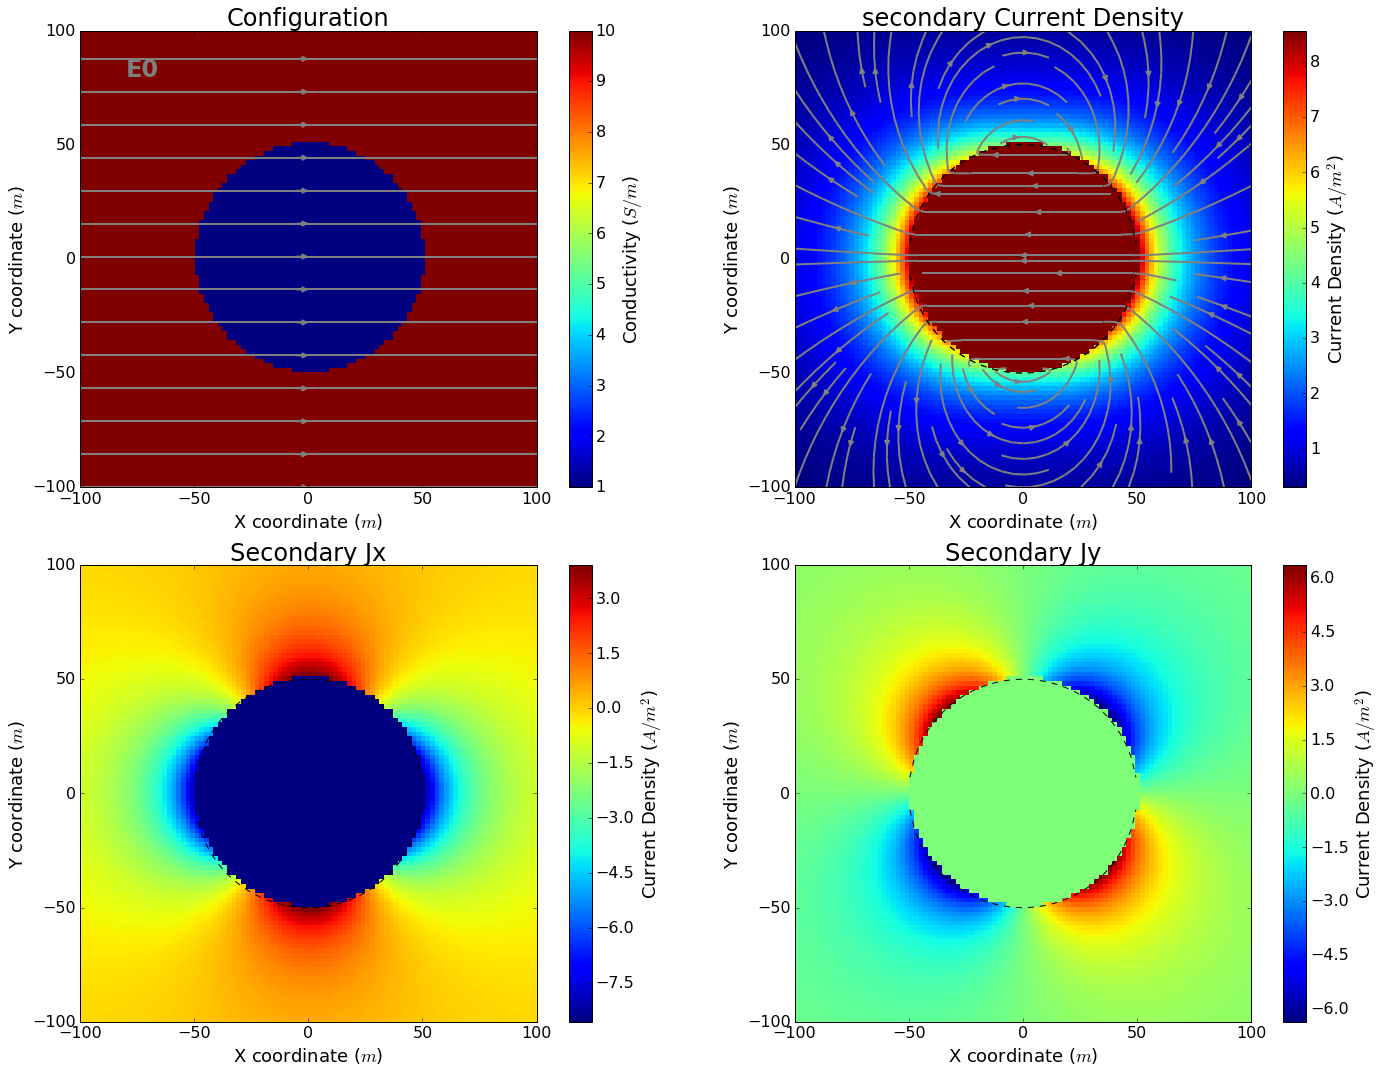

In [28]:
# Interactice visualisation of the current density
 
R_slider  = FloatSlider(min=0., max =50., step=10., value=50.)
S1_slider = FloatSlider(min=1., max =100., step=1.,value=1.)
S0_slider = FloatSlider(min=1., max =100., step=1.,value=10.)
E0_slider = FloatSlider(min=-10., max =10., step=2., value=1.)
PlotOpt_button = ToggleButtons(options=['Total','Secondary'],value = 'Total')

def plot_Currents(R,sig1,sig0,E0,PlotOpt):
   
    Sigma = get_Conductivity(XYZ,sig0,sig1,R)
    Et, Ep, Es = get_ElectricField(XYZ,sig0,sig1,R,E0)
    Jt,Jp,Js = get_Current(XYZ,sig0,sig1,R,Et,Ep,Es)
    
    xcirc = xr[np.abs(xr) <= R]

    JtXr = Jt[:,0].reshape(xr.size, yr.size)
    JtYr = Jt[:,1].reshape(xr.size, yr.size)
    JtAmp = np.sqrt(Jt[:,0]**2+Jt[:,1]**2+Jt[:,2]**2).reshape(xr.size, yr.size)
    
    JsXr = Js[:,0].reshape(xr.size, yr.size)
    JsYr = Js[:,1].reshape(xr.size, yr.size)
    JsAmp = np.sqrt(Js[:,1]**2+Js[:,0]**2+Jt[:,2]**2).reshape(xr.size,yr.size)
    
    fig,ax = plt.subplots(2,2,figsize=(20,15))
    ax=mkvc(ax)

    ax[0].pcolor(xr,yr,Sigma.reshape(xr.size, yr.size))
    cb0 = plt.colorbar(ax[0].pcolor(xr,yr,Sigma.reshape(xr.size, yr.size)),ax=ax[0])
    cb0.set_label(label= 'Conductivity ($S/m$)',size=ftsize_label) #weight='bold')
    cb0.ax.tick_params(labelsize=ftsize_axis)
    ax[0].streamplot(xr,yr,Ep[:,0].reshape(xr.size,yr.size),Ep[:,1].reshape(xr.size,yr.size),color='gray'
                     ,linewidth=2.,density=0.5)
    #ax[0].quiver(np.zeros_like(xrr)-90,yrr,E0,0,angles='xy',scale_units='xy',scale=0.05,color='gray')
    #ax[0].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
    ax[0].set_title('Configuration',fontsize=ftsize_title)
    ax[0].annotate('E0',(-80,80),xytext=(-80,80),fontsize=ftsize_title,color='gray',weight='bold')
    ax[0].set_xlim([xr.min(),xr.max()])
    ax[0].set_ylim([yr.min(),yr.max()])
    ax[0].set_ylabel('Y coordinate ($m$)',fontsize=ftsize_label)
    ax[0].set_xlabel('X coordinate ($m$)',fontsize=ftsize_label)
    ax[0].tick_params(labelsize=ftsize_axis)
    ax[0].set_aspect('equal')
    
    ax[1].set_xlim([xr.min(),xr.max()])
    ax[1].set_ylim([yr.min(),yr.max()])
    ax[1].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
    ax[1].set_ylabel('Y coordinate ($m$)',fontsize=ftsize_label)
    ax[1].set_xlabel('X coordinate ($m$)',fontsize=ftsize_label)
    ax[1].tick_params(labelsize=ftsize_axis)
    ax[1].set_aspect('equal')
    
    ax[2].set_xlim([xr.min(),xr.max()])
    ax[2].set_ylim([yr.min(),yr.max()])
    ax[2].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
    ax[2].set_ylabel('Y coordinate ($m$)',fontsize=ftsize_label)
    ax[2].set_xlabel('X coordinate ($m$)',fontsize=ftsize_label)
    ax[2].tick_params(labelsize=ftsize_axis)
    ax[2].set_aspect('equal')
    
    ax[3].set_xlim([xr.min(),xr.max()])
    ax[3].set_ylim([yr.min(),yr.max()])    
    ax[3].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
    ax[3].set_ylabel('Y coordinate ($m$)',fontsize=ftsize_label)
    ax[3].set_xlabel('X coordinate ($m$)',fontsize=ftsize_label)
    ax[3].tick_params(labelsize=ftsize_axis)
    ax[3].set_aspect('equal')

    if PlotOpt == 'Total':
        
        ax[2].pcolor(xr,yr,JtAmp)
        cb2 = plt.colorbar(ax[2].pcolor(xr,yr,JtAmp),ax=ax[2])
        cb2.set_label(label= 'Current Density ($A/m^2$)',size=ftsize_label) #weight='bold')
        cb2.ax.tick_params(labelsize=ftsize_axis)
        ax[2].streamplot(xr,yr,JtXr,JtYr,color='gray',linewidth=2.,density=0.75)#,angles='xy',scale_units='xy',scale=1)
        ax[2].set_title('Total Current Density',fontsize=ftsize_title)

        ax[1].pcolor(xr,yr,JtXr)
        cb1 = plt.colorbar(ax[1].pcolor(xr,yr,JtXr),ax=ax[1])
        cb1.set_label(label= 'Current Density ($A/m^2$)',size=ftsize_label) #weight='bold')
        cb1.ax.tick_params(labelsize=ftsize_axis)
        ax[1].set_title('Total Jx',fontsize=ftsize_title)

        ax[3].pcolor(xr,yr,JtYr)
        cb3 = plt.colorbar(ax[3].pcolor(xr,yr,JtYr),ax=ax[3])
        cb3.set_label(label= 'Current Density ($A/m^2$)',size=ftsize_label) #weight='bold')
        cb3.ax.tick_params(labelsize=ftsize_axis)
        ax[3].set_title('Total Jy',fontsize=ftsize_title)

    elif PlotOpt == 'Secondary':
        
        ax[2].pcolor(xr,yr,JsAmp)
        cb2 = plt.colorbar(ax[2].pcolor(xr,yr,JsAmp),ax=ax[2])
        cb2.set_label(label= 'Current Density ($A/m^2$)',size=ftsize_label) #weight='bold')
        cb2.ax.tick_params(labelsize=ftsize_axis)
        ax[2].streamplot(xr,yr,JsXr,JsYr,color='gray',linewidth=2.)#angles='xy',scale_units='xy',scale=1)
        ax[2].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
        ax[2].set_xlim([xr.min(),xr.max()])
        ax[2].set_ylim([yr.min(),yr.max()])
        ax[2].set_title('secondary Current Density',fontsize=ftsize_title)
        
        ax[1].pcolor(xr,yr,JsXr)
        cb1 = plt.colorbar(ax[1].pcolor(xr,yr,JsXr),ax=ax[1])
        cb1.set_label(label= 'Current Density ($A/m^2$)',size=ftsize_label) #weight='bold')
        cb1.ax.tick_params(labelsize=ftsize_axis)
        ax[1].set_title('Secondary Jx',fontsize=ftsize_title)

        ax[3].pcolor(xr,yr,Js[:,1].reshape(xr.size,yr.size))
        cb3 = plt.colorbar(ax[3].pcolor(xr,yr,JsYr),ax=ax[3])
        cb3.set_label(label= 'Current Density ($A/m^2$)',size=ftsize_label) #weight='bold')
        cb3.ax.tick_params(labelsize=ftsize_axis)
        ax[3].set_title('Secondary Jy',fontsize=ftsize_title)
        
    else:
        print('Oups')
    
    plt.tight_layout()
    
    
interact(plot_Currents, R=R_slider, sig1=S1_slider, sig0=S0_slider,E0=E0_slider,PlotOpt=PlotOpt_button)

# Charge Accumulation computation

According to Gauss's law,
$$ \nabla\cdot \epsilon\mathbf{E} = \rho_v $$

Taking volume integral gives us charge distribution
$$ \int_v \nabla \cdot \epsilon\mathbf{E} = \int_v \rho_v dv = Q$$

Considering an infinitesimal surface at the boundary of two media, based on Gauss theorem, we can get surface charge density at the interface
$$(\mathbf{E_1\cdot n} - \mathbf{E_2\cdot n}) = \frac{\rho_s}{\epsilon} $$

So the discontinuity of normal electric field between two media is caused by charge accumulation on the interface.

The normal component of electric fields at the spherical surface are (spherical coordinate)
$$ E_{1n} = E_0\cos\theta + 2E_0\frac{\sigma_1-\sigma_0}{\sigma_1+2\sigma_1}\cos\theta  \quad (r>R) $$ 
$$ E_{2n} = E_0\frac{3\sigma_0}{\sigma_1+2\sigma_0}\cos\theta \quad (r<R) $$

So the charge accumulation at the surface is
$$ \oint_S\rho_sdS = {\epsilon}\oint_S(E_{1n}-E_{2n})dS = {\epsilon}\oint_S 3E_0\frac{\sigma_1-\sigma_0}{\sigma_1+2\sigma_0}\cos\theta R^2 \sin\theta d\phi d\theta $$

In [19]:
def get_ChargesDensity(XYZ,sig0,sig1,R,Et,Ep):
    
    x,y,z= XYZ[:,0], XYZ[:,1], XYZ[:,2]
    
    r_cur=r(x,y,z)
    
    ind0 = (r_cur > R)
    ind1 = (r_cur < R)
    ind2 = ((r_cur < (R+dx/2)) & (r_cur > (R-dx/2)) )
    
    assert (ind0 + ind1 + ind2).all(), 'Some indicies not included'
    
    rho = np.zeros_like(x)
    
    rho[ind0] = 0
    rho[ind1] = 0
    rho[ind2] = epsilon_0*3.*Ep[ind2,0]*sigf(sig0,sig1)*x[ind2]/(np.sqrt(x[ind2]**2.+y[ind2]**2.))
    
    return rho

<function __main__.plot_Charges>

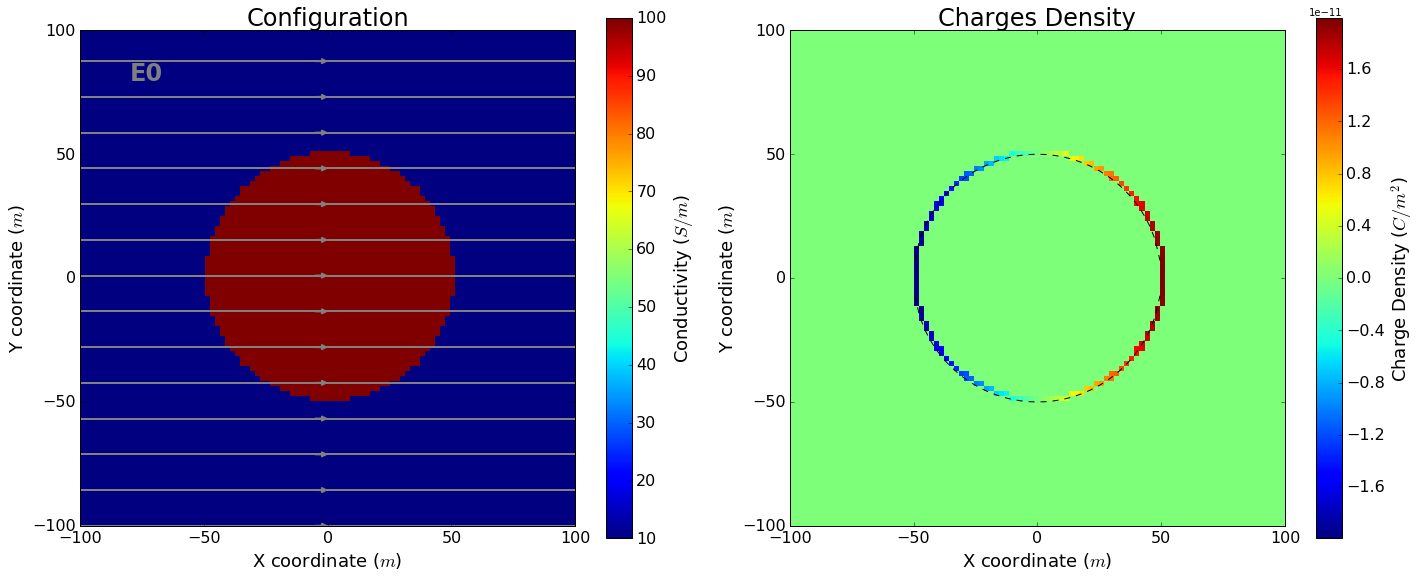

In [29]:
#Interavtice visualisation of the charge accumulation

R_slider  = FloatSlider(min=0., max =50., step=10., value=50.)
S1_slider = FloatSlider(min=1., max =100., step=1.,value=100.)
S0_slider = FloatSlider(min=1., max =100., step=1.,value=10.)
E0_slider = FloatSlider(min=-10., max =10., step=2., value=1.)

def plot_Charges(R,sig0,sig1,E0):
   
    Sigma = get_Conductivity(XYZ,sig0,sig1,R)
    Et, Ep, Es = get_ElectricField(XYZ,sig0,sig1,R,E0)
    rho = get_ChargesDensity(XYZ,sig0,sig1,R,Et,Ep)
    
    xcirc = xr[np.abs(xr) <= R]
    
    fig,ax = plt.subplots(1,2,figsize=(20,8))

    ax[0].pcolor(xr,yr,Sigma.reshape(xr.size, yr.size))
    cb0 = plt.colorbar(ax[0].pcolor(xr,yr,Sigma.reshape(xr.size, yr.size)),ax=ax[0])
    cb0.set_label(label= 'Conductivity ($S/m$)',size=ftsize_label) #weight='bold')
    cb0.ax.tick_params(labelsize=ftsize_axis)
    ax[0].streamplot(xr,yr,Ep[:,0].reshape(xr.size,yr.size),Ep[:,1].reshape(xr.size,yr.size),color='gray'
                     ,density=0.5, linewidth=2.)
    #ax[0].quiver(np.zeros_like(xrr)-90,yrr,E0,0,angles='xy',scale_units='xy',scale=0.05,color='gray')
    #ax[0].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
    ax[0].set_title('Configuration',fontsize=ftsize_title)
    ax[0].annotate('E0',(-80,80),xytext=(-80,80),fontsize=ftsize_title,color='gray',weight='bold')
    ax[0].set_xlim([xr.min(),xr.max()])
    ax[0].set_ylim([yr.min(),yr.max()])
    ax[0].set_ylabel('Y coordinate ($m$)',fontsize=ftsize_label)
    ax[0].set_xlabel('X coordinate ($m$)',fontsize=ftsize_label)
    ax[0].set_aspect('equal')
    ax[0].tick_params(labelsize=ftsize_axis)
    
    ax[1].set_xlim([xr.min(),xr.max()])
    ax[1].set_ylim([yr.min(),yr.max()])
    ax[1].set_aspect('equal')
    ax[1].pcolor(xr,yr,rho.reshape(xr.size, yr.size))
    cb1 = plt.colorbar(ax[1].pcolor(xr,yr,rho.reshape(xr.size, yr.size)),ax=ax[1])
    cb1.set_label(label= 'Charge Density ($C/m^2$)',size=ftsize_label) #weight='bold')
    cb1.ax.tick_params(labelsize=ftsize_axis)
    ax[1].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
    ax[1].set_ylabel('Y coordinate ($m$)',fontsize=ftsize_label)
    ax[1].set_xlabel('X coordinate ($m$)',fontsize=ftsize_label)
    ax[1].tick_params(labelsize=ftsize_axis)
    ax[1].set_title('Charges Density', fontsize=ftsize_title)
    

    plt.tight_layout()
    
interact(plot_Charges, R=R_slider, sig1=S1_slider,sig0=S0_slider, E0=E0_slider)

# M-N Potential differential Measurements

In [21]:
#Defining and computing potential differences from a chosen MN dipole

def MN_Potential_total(sig0,sig1,R,E0,start,end,nbmp,mn):
    
    #sig0: background conductivity
    #sig1: sphere conductivity
    #R: Sphere's radius
    #E0: uniform E field value
    #start: start point for the profile start.shape = (2,)
    #end: end point for the profile end.shape = (2,)
    #nbmp: number of dipoles
    #mn: Space between the M and N electrodes

    #D: total distance from start to end
    D = np.sqrt((start[0]-end[0])**2.+(start[1]-end[1])**2.)
    
    #MP: dipoles'midpoint positions (x,y)
    MP = np.zeros(shape=(nbmp,2))                            
    MP[:,0] = np.linspace(start[0],end[0],nbmp)
    MP[:,1] = np.linspace(start[1],end[1],nbmp)
    
    #Dipoles'Electrodes positions around each midpoints
    EL = np.zeros(shape=(2*nbmp,2))                         
    for n in range(0,len(EL),2):
        EL[n,0]   = MP[n/2,0] - ((end[0]-start[0])/D)*mn/2.
        EL[n+1,0] = MP[n/2,0] + ((end[0]-start[0])/D)*mn/2.
        EL[n,1]   = MP[n/2,1] - ((end[1]-start[1])/D)*mn/2.
        EL[n+1,1] = MP[n/2,1] + ((end[1]-start[1])/D)*mn/2.
    
    VtEL = np.zeros(2*nbmp) #Total Potential (Vt-) at each electrode (-EL)
    VsEL = np.zeros(2*nbmp) #Secondary Potential (Vt-) at each electrode (-EL)
    dVtMP = np.zeros(nbmp)  #Diffence (d-) of Total Potential (Vt-) at each dipole (-MP)
    dVtMPn = np.zeros(nbmp) #Diffence (d-) of Total Potential (Vt-) at each dipole (-MP) normalized for the mn spacing (n)
    dVsMP = np.zeros(nbmp)  #Diffence (d-) of Secondaty Potential (Vt-) at each dipole (-MP)
    dVsMPn = np.zeros(nbmp) #Diffence (d-) of Secondary Potential (Vt-) at each dipole (-MP) normalized for the mn spacing (n)
    dVpMP = np.zeros(nbmp) #Diffence (d-) of Primary Potential (Vt-) at each dipole (-MP)
    dVpMPn = np.zeros(nbmp) #Diffence (d-) of Primary Potential (Vt-) at each dipole (-MP) normalized for the mn spacing (n)
    
    #Computing VtEL 
    for m in range(0,2*nbmp):
        if (r(EL[m,0],EL[m,1],0) > R):
            VtEL[m] = -E0*EL[m,0]*(1.-sigf(sig0,sig1)*R**3./r(EL[m,0],EL[m,1],0)**3.)
        else:
            VtEL[m] = -E0*EL[m,0]*3.*sig0/(sig1+2.*sig0)
    
    #Computing VsEL
    VsEL = VtEL + E0*EL[:,0]
    
    #Computing dVtMP, dVsMP
    for p in range(0,nbmp):
        dVtMP[p] = VtEL[2*p]-VtEL[2*p+1]
        dVtMPn[p] = dVtMP[p]/mn
        dVsMP[p] = VsEL[2*p]-VsEL[2*p+1]
        dVsMPn[p] = dVsMP[p]/mn
    
    return MP,EL,dVtMP,dVtMPn,dVsMP,dVsMPn

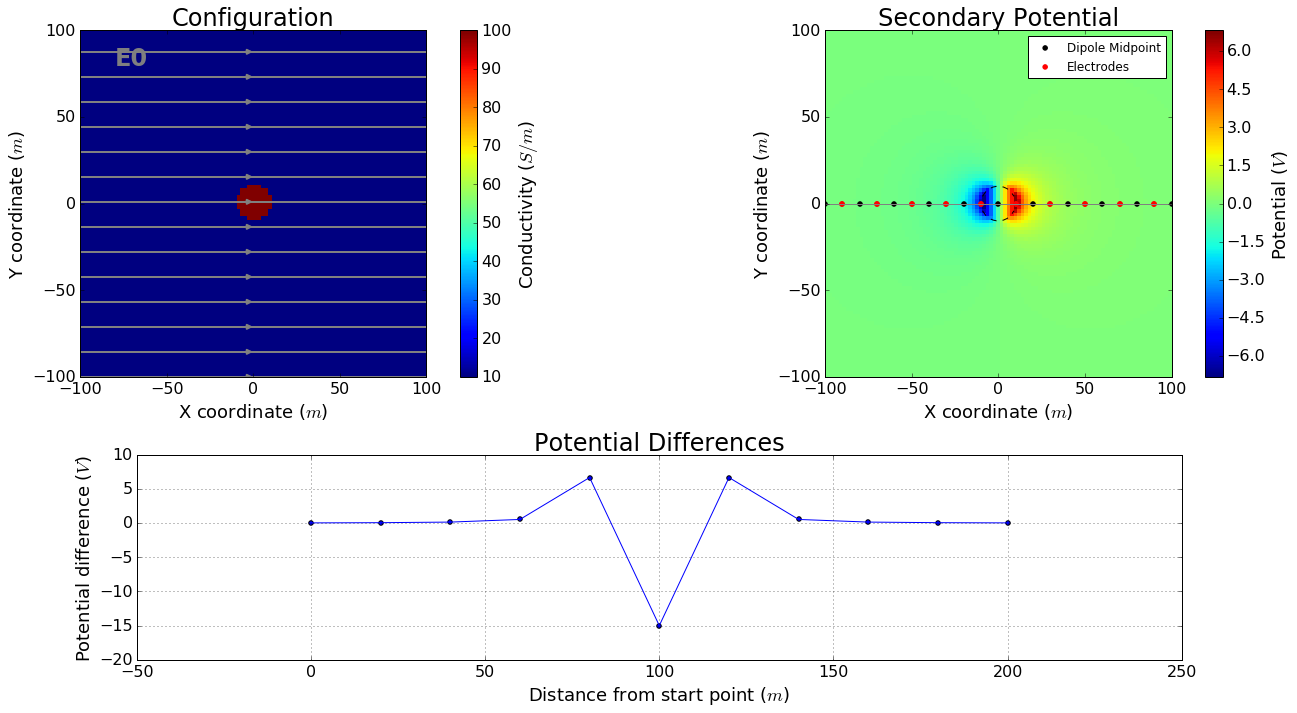

In [30]:
##### Interactive tool to visualise synthetic data from a profile line of MN dipoles

PlotOpt_button = ToggleButtons(options=['Total','Secondary'],value = 'Total')
R_slider  = FloatSlider(min=0., max =50., step=10.,value=10.)
S1_slider = FloatSlider(min=1., max =100., step=1.,value=100.)
S0_slider = FloatSlider(min=1., max =100., step=1.,value=10.)
E0_slider = FloatSlider(min=-10., max =10., step=1.,value=1.)
x_start = FloatSlider(min=-100., max =100., step=10.,value=-100.)
y_start = FloatSlider(min=-100., max =100., step=10.,value=0.)
x_end = FloatSlider(min=-100., max =100., step=10.,value=100.)
y_end = FloatSlider(min=-100., max =100., step=10.,value=0.)
dipole_number = IntSlider(min=1, max =40, step=10,value=11)
MN_spacing = FloatSlider(min=0., max =25., step=5.,value=20.)

#start= np.array([-100,75])
#end=[100,75]
#nbmp=10
#mn=20

def plot_PotentialDifferences(sig0,sig1,R,E0,xstart,ystart,xend,yend,nb_dipole,electrode_spacing,PlotOpt):
    
    start = np.array([xstart,ystart])
    end = np.array([xend,yend])
    
    Sigma    = get_Conductivity(XYZ,sig0,sig1,R)
    Vt,Vp,Vs = get_Potential(XYZ,sig0,sig1,R,E0)
    MP,EL,VtdMP,VtdMPn,VsdMP,VsdMPn = MN_Potential_total(sig0,sig1,R,E0,start,end,nb_dipole,electrode_spacing)
    
    Ep = np.zeros(shape=(len(Sigma),3))
    Ep[:,0] = E0

    xcirc = xr[np.abs(xr) <= R]

    #fig,ax = plt.subplots(1,3,figsize=(20,5))
    #ax=mkvc(ax)
    
    fig = plt.figure(figsize=(20,10))
    ax0 = plt.subplot2grid((10,12), (0, 0),colspan=6,rowspan=6)
    ax1 = plt.subplot2grid((10,12), (0, 6),colspan=6,rowspan=6)
    ax2 = plt.subplot2grid((10,12), (6, 2), colspan=9,rowspan=4)


    ax0.pcolor(xr,yr,Sigma.reshape(xr.size, yr.size))
    cb0 = plt.colorbar(ax0.pcolor(xr,yr,Sigma.reshape(xr.size, yr.size)),ax=ax0)
    cb0.set_label(label= 'Conductivity ($S/m$)',size=ftsize_label) #weight='bold')
    cb0.ax.tick_params(labelsize=ftsize_axis)
    ax0.streamplot(xr,yr,Ep[:,0].reshape(xr.size,yr.size),Ep[:,1].reshape(xr.size,yr.size),color='gray'
                    ,density=0.5,linewidth=2.)
    #ax[0].quiver(np.zeros_like(xrr)-90,yrr,E0,0,angles='xy',scale_units='xy',scale=0.05,color='gray')
    #ax[0].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
    ax0.set_title('Configuration',fontsize=ftsize_title)
    ax0.annotate('E0',(-80,80),xytext=(-80,80),fontsize=ftsize_title,color='gray',weight='bold')
    ax0.set_xlim([xr.min(),xr.max()])
    ax0.set_ylim([yr.min(),yr.max()])
    ax0.set_ylabel('Y coordinate ($m$)',fontsize=ftsize_label)
    ax0.set_xlabel('X coordinate ($m$)',fontsize=ftsize_label)
    ax0.tick_params(labelsize=ftsize_axis)
    ax0.set_aspect('equal')
    
    ax1.set_xlim([xr.min(),xr.max()])
    ax1.set_ylim([yr.min(),yr.max()])
    ax1.plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
    ax1.set_ylabel('Y coordinate ($m$)',fontsize=ftsize_label)
    ax1.set_xlabel('X coordinate ($m$)',fontsize=ftsize_label)
    ax1.tick_params(labelsize=ftsize_axis)
    ax1.set_aspect('equal')
    
    ax2.set_title('Potential Differences',fontsize=ftsize_title)
    ax2.set_ylabel('Potential difference ($V$)',fontsize=ftsize_label)
    ax2.set_xlabel('Distance from start point ($m$)',fontsize=ftsize_label)
    ax2.tick_params(labelsize=ftsize_axis)
    ax2.grid()

    if PlotOpt == 'Total':

        ax1.pcolor(xr,yr,Vt.reshape(xr.size,yr.size))
        cb1 = plt.colorbar(ax1.pcolor(xr,yr,Vt.reshape(xr.size, yr.size)),ax=ax1)
        cb1.set_label(label= 'Potential ($V$)',size=ftsize_label) #weight='bold')
        cb1.ax.tick_params(labelsize=ftsize_axis)
        ax1.set_title('Total Potential',fontsize=ftsize_title)
               
        ax2.plot(np.sqrt((MP[0,0]-MP[:,0])**2+(MP[:,1]-MP[0,1])**2),VtdMP)
        ax2.scatter(np.sqrt((MP[0,0]-MP[:,0])**2+(MP[:,1]-MP[0,1])**2),VtdMP)

    elif PlotOpt == 'Secondary':
               
        ax1.pcolor(xr,yr,Vs.reshape(xr.size,yr.size))
        ax1.set_title('Secondary Potential',fontsize=ftsize_title)
        cb1 = plt.colorbar(ax1.pcolor(xr,yr,Vs.reshape(xr.size, yr.size)),ax=ax1)
        cb1.set_label(label= 'Potential ($V$)',size=ftsize_label) #weight='bold')
        cb1.ax.tick_params(labelsize=ftsize_axis)

        ax2.plot(np.sqrt((MP[0,0]-MP[:,0])**2+(MP[:,1]-MP[0,1])**2),VsdMP)
        ax2.scatter(np.sqrt((MP[0,0]-MP[:,0])**2+(MP[:,1]-MP[0,1])**2),VsdMP)

    else:
        print('What dont you get? Total or Secondary?')
    
    ax1.plot(MP[:,0],MP[:,1],color='gray')           
    Dip_Midpoint = ax1.scatter(MP[:,0],MP[:,1],color='black')
    Electrodes = ax1.scatter(EL[:,0],EL[:,1],color='red')
    ax1.legend([Dip_Midpoint,Electrodes], ["Dipole Midpoint", "Electrodes"],scatterpoints=1)
    
    plt.tight_layout()
    
interact(plot_PotentialDifferences, R=R_slider, sig1=S1_slider, sig0=S0_slider,E0=E0_slider, 
         xstart=x_start,xend=x_end,ystart=y_start,yend=y_end,PlotOpt=PlotOpt_button,
        nb_dipole=dipole_number,electrode_spacing=MN_spacing)
